In [13]:
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np
import MetaTrader5 as mt5
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import vectorbt as vbt
from pandas.tseries.offsets import BDay
from tqdm import tqdm
from random import randint
from pykalman import KalmanFilter

In [9]:
def get_bars(symbol, start_date, end_date, timeframe=mt5.TIMEFRAME_M1):
    mt5.initialize()
    bars = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    df_bars = pd.DataFrame(bars)
    df_bars["time"] = pd.to_datetime(df_bars["time"], unit="s")
    return df_bars

In [10]:
def get_prices(location):
    mt5.initialize()

    symbol_list = []
    for symbol in mt5.symbols_get():
        if location in symbol.path:
            symbol_list.append(symbol)
            
    return symbol_list

In [18]:
def backtest(symbol, slow_ma, slow_std, fast_ma, volume, volume_ma, volume_std):
    
    LONG = 1
    SHORT = -1
    FREE = 0

    account = 1000
    
    position_type = FREE
    position_entry = 0
    high_counter = 0
    low_counter = 0
    
    leverage = 2
     
    for t in range(1, len(symbol)):
        
        
        #print(f'EURUSD: {adjusted_eurusd[i]}, FMA: {adjusted_fast_ma[i]}, SMA: {adjusted_slow_ma[i]}, SSD: {adjusted_slow_std[i]}')
        

        ################################################
        
        ########## US500 ###########################
        upper_threshold = slow_ma + slow_std *0.6
        lower_threshold = slow_ma - slow_std * 0.6
        
        vol_threshold = volume_ma + volume_std 
        
        ################################################
        
        #upper_threshhold = slow_ma + slow_std * 0.01
        #lower_threshold = slow_ma - slow_std * 0.01
        
        #vol_threshhold = volume_ma + volume_std
        
        
        if vol_threshold[t] == None:
            continue
        
        # If Long
        if position_type == LONG:
            
            if (fast_ma.iloc[t-1] >= slow_ma.iloc[t-1]) and (fast_ma.iloc[t] < slow_ma.iloc[t]):
                #print(f'close long: {symbol.iloc[t]}, CHANGE: {symbol.iloc[t] - position_entry}')
                account += account * leverage * ((symbol.iloc[t] - position_entry) / symbol.iloc[t])
                high_counter += 1
                position_type = FREE
                #print(f'account: {account}')  
            elif (position_entry - symbol.iloc[t]) >= 3 * (slow_ma.iloc[t] + slow_std.iloc[t]):
                #print(f'UPPER LOSS:')
                account -= account * ((position_entry[t] - symbol.iloc[t]) / symbol.iloc[t])
                #high_counter += 1
                position_type = FREE
                #print(f'account: {account}')
                
        elif position_type == SHORT:        
            if (fast_ma.iloc[t-1] <= slow_ma.iloc[t-1]) and (fast_ma.iloc[t] > slow_ma.iloc[t]):
                #print(f'close short: {symbol.iloc[t]}, CHANGE: {position_entry - symbol.iloc[t]}')
                account += account * leverage *  ((position_entry - symbol.iloc[t]) / symbol.iloc[t])
                low_counter += 1
                position_type = FREE
                #print(f'account: {account}')  
            elif (symbol.iloc[t] - position_entry) >= 3 * (slow_ma.iloc[t] + slow_std.iloc[t]):
                #print(f'LOWER LOSS:')
                account -= account * 3 * ((symbol.iloc[t] - position_entry) / symbol.iloc[t])
                #low_counter += 1
                position_type = FREE
                #print(f'account: {account}')
                
                
        elif position_type == FREE:
            # cross above -> long

            if (fast_ma.iloc[t-1] <= upper_threshold.iloc[t-1]) and (fast_ma.iloc[t] >= upper_threshold.iloc[t]) and volume[t] >= vol_threshold[t]:
                position_type = LONG
                position_entry = symbol.iloc[t]
                account -= 1
                #print(f'open long: {symbol.iloc[t]}')
                #print(f'account: {account}')
            # cross below -> short
            elif (fast_ma.iloc[t-1] >= lower_threshold.iloc[t-1]) and (fast_ma.iloc[t] <= lower_threshold.iloc[t]) and volume[t] >= vol_threshold[t]:
                position_type = SHORT
                position_entry = symbol.iloc[t]
                #print(f'open short: {symbol.iloc[t]}')
                #print(f'account: {account}')
            
            
           
            
                        
    #print(f'trades: {trade_counter}')
    #print(f'account: {account}')
    
    
    return account, high_counter, low_counter

DAY: 0, DATE: 2022-12-22 00:48:25.226191, DAY: Thursday 		 BALANCE: 1016.2345633631357, TOTAL: 19
ACCOUNT VALUE: 1016.2345633631357
DAY: 1, DATE: 2023-01-26 00:48:25.611995, DAY: Thursday 		 BALANCE: 1042.0913691977728, TOTAL: 9
ACCOUNT VALUE: 1058.3259325609085
DAY: 2, DATE: 2023-02-28 00:48:26.006532, DAY: Tuesday 		 BALANCE: 1013.123544225792, TOTAL: 14
ACCOUNT VALUE: 1071.4494767867004
HP filter acting funny, skipping.
DAY: 4, DATE: 2023-01-17 00:48:26.403385, DAY: Tuesday 		 BALANCE: 1016.9548943278053, TOTAL: 7
ACCOUNT VALUE: 1088.4043711145057
DAY: 5, DATE: 2023-03-08 00:48:26.730068, DAY: Wednesday 		 BALANCE: 1025.1113560094623, TOTAL: 16
ACCOUNT VALUE: 1113.515727123968
DAY: 6, DATE: 2023-02-24 00:48:27.116986, DAY: Friday 		 BALANCE: 1027.022557743673, TOTAL: 16
ACCOUNT VALUE: 1140.5382848676409
DAY: 7, DATE: 2022-12-20 00:48:27.485625, DAY: Tuesday 		 BALANCE: 1021.2472128942464, TOTAL: 16
ACCOUNT VALUE: 1161.7854977618872
DAY: 8, DATE: 2023-02-14 00:48:27.874821, DAY: Tues

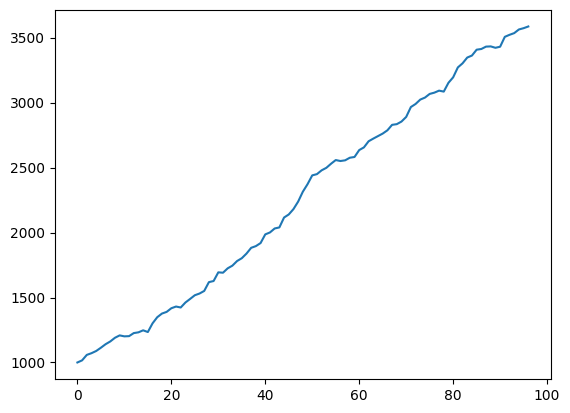

In [20]:
mt5.initialize()
us500 = mt5.symbols_get('US500')
    
    
balance = 1000
performance = [balance]
for epoch in range(100):
    
     # Monte Carlo simulation
    while True:
        end_date = datetime.now() - timedelta(days = randint(1, 100))
        if end_date.weekday() < 5 and end_date.weekday() > 0:
            break
      
    
    start_date = end_date - timedelta(days=1)
    
    us500_close = get_bars(us500[0].name, start_date, end_date)['close']
    us500_vol = get_bars(us500[0].name, start_date, end_date)['tick_volume']
    
    try:
        filtered_us500_close_cycle, filtered_us500_close_trend = sm.tsa.filters.hpfilter(us500_close)
        filtered_us500_vol_cycle, filtered_us500_vol_trend = sm.tsa.filters.hpfilter(us500_vol)
    except ValueError:
        print("HP filter acting funny, skipping.")
        continue
    
    
    window_vol = 90
    us500_vol_mean = filtered_us500_vol_trend.rolling(window_vol).mean()
    us500_vol_std = filtered_us500_vol_trend.rolling(window_vol).std()
    
    #plt.plot(filtered_us500_vol_trend)
    
    window_slow = 50
    window_fast = 10
    slow_ma = filtered_us500_close_trend.ewm(span=window_slow).mean()
    slow_std = filtered_us500_close_trend.ewm(span=window_slow).std()
    fast_ma = filtered_us500_close_trend.ewm(span=window_fast).mean()
    
    #print(us500_vol_mean)
    #print(us500_vol_std)
    
    account, high_counter, low_counter = backtest(
                                            us500_close, 
                                            slow_ma, 
                                            slow_std, 
                                            fast_ma,
                                            filtered_us500_close_trend,
                                            us500_vol_mean,
                                            us500_vol_std) 
    
    print(f'DAY: {epoch}, DATE: {end_date}, DAY: {end_date.strftime("%A")} \t\t BALANCE: {account}, TOTAL: {high_counter + low_counter}')
    
    if account < 1000:
        balance -= (1000 - account)
    elif account > 1000:
        balance += (account - 1000)
        
        
    performance.append(balance)    
    print(f'ACCOUNT VALUE: {balance}')
        
plt.plot(performance)

In [ ]:
import pmdarima as pm

def get_optimal_arima(time_series):
    """
    This function takes a time series as input and uses the auto_arima 
    function from the pmdarima library to find the optimal ARIMA model for 
    the time series.
    
    Parameters:
    -----------
    time_series : pd.Series
        The time series for which to find the optimal ARIMA model
    
    Returns:
    --------
    pmdarima.arima.ARIMA
        The optimal ARIMA model for the time series
    """
    # Use the auto_arima function to find the optimal ARIMA model
    model = pm.auto_arima(time_series, seasonal=False, suppress_warnings=True)
    
    # Return the optimal ARIMA model
    return model


In [ ]:
#Get initial data and save to csv

#1 Create an event handler in python to get the latest data
#2 save the data to the data csv
#3 construct metrics 
#4 test latest data against metrics
#5 place buy or sell orders based on metrics